In [45]:
import torch
import botorch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# BO Comparison Visualization

In [46]:
opt_var_names = ['SOL1:solenoid_field_scale','CQ01:b1_gradient', 'SQ01:b1_gradient',
                 "QA01:b1_gradient", "QA02:b1_gradient", 
                 "QE01:b1_gradient", "QE02:b1_gradient", "QE03:b1_gradient", "QE04:b1_gradient"]
bounds = torch.as_tensor([[0.46, 0.485], [-0.02, 0.02], [-0.02, 0.02],
                       [-4, -1], [1, 4],
                       [-7,-1], [-1, 7],[-1, 7], [-7, 1]])

## Mean Curve and Std Error for Best -emittance*bmag 

tensor([-1.8533, -1.6653, -1.4722, -1.3810, -1.2913, -1.1894, -1.1076, -1.0896,
        -1.0549, -1.0191, -0.9883, -0.9790, -0.9161, -0.8964, -0.8897, -0.8750,
        -0.8425, -0.8351, -0.8254, -0.8190, -0.8137, -0.7974, -0.7918, -0.7779,
        -0.7721, -0.7627, -0.7560, -0.7438, -0.7432, -0.7422, -0.7365, -0.7327,
        -0.7321, -0.7287, -0.7244, -0.7212, -0.7169, -0.7158, -0.7110, -0.7077,
        -0.7064, -0.6979, -0.6918, -0.6897, -0.6873, -0.6870, -0.6855, -0.6827,
        -0.6808, -0.6808, -0.6772])
tensor([-1.8533, -0.7636, -0.7140, -0.6950, -0.6790, -0.6729, -0.6691, -0.6619,
        -0.6535, -0.6497, -0.6470, -0.6408, -0.6408, -0.6381, -0.6376, -0.6373,
        -0.6358, -0.6338, -0.6322, -0.6302, -0.6293, -0.6283, -0.6266, -0.6261,
        -0.6256, -0.6244, -0.6216, -0.6203, -0.6185, -0.6185, -0.6184, -0.6165,
        -0.6165, -0.6165, -0.6164, -0.6164, -0.6151, -0.6150, -0.6139, -0.6133,
        -0.6133, -0.6129, -0.6129, -0.6122, -0.6116, -0.6100, -0.6100, -0.6100,
    

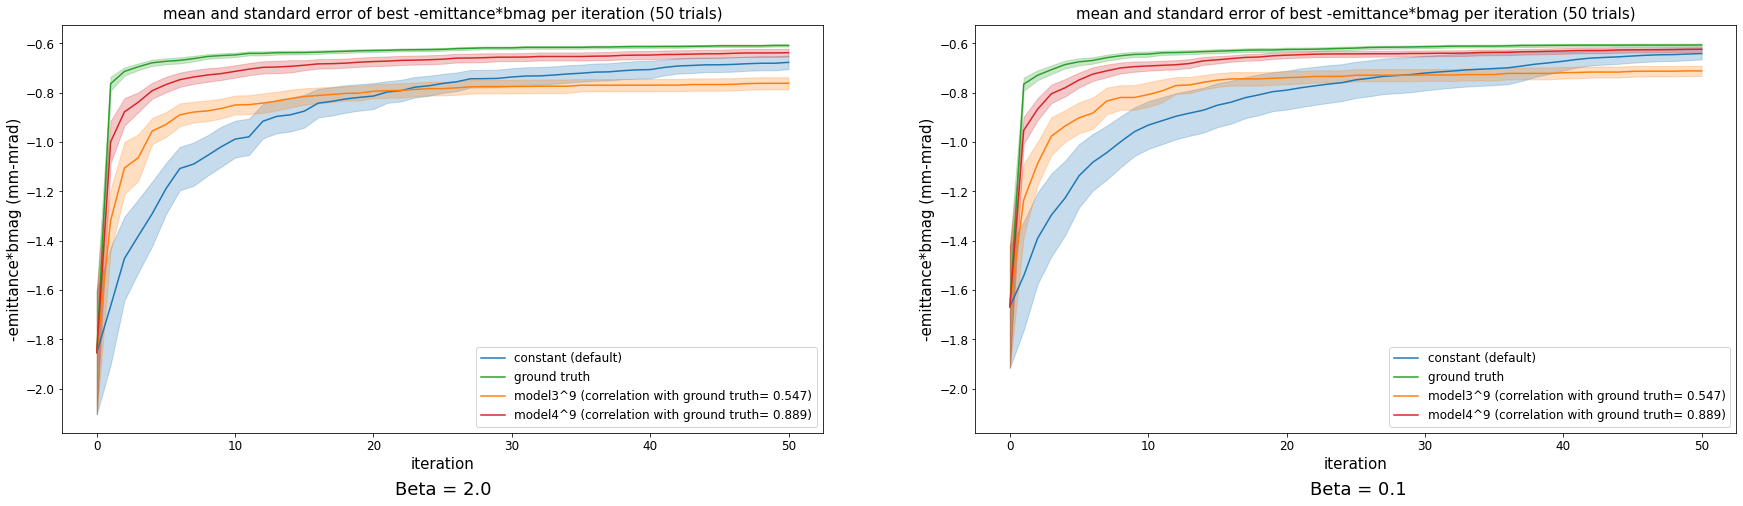

In [47]:
filenames = ['surr_const_model3_model4_2.0_50iter', 'surr_const_model3_model4_0.1_50iter'] # specify files to be visualized

# for each file in filenames, plot best_y (best -emittance*bmag) mean and std error for each BO run
fig, axes = plt.subplots(1, len(filenames), sharey=True)

colors = ['C0','C2','C1','C3','C4']
correlation = [0.547, 0.889, 0.0, 0.0] # calculated in priors_correlation_plots.ipynb  TODO: create correlation_calculation.py

transformer_x = botorch.models.transforms.input.Normalize(9, bounds = bounds.transpose(0,1))

for file_index, ax in enumerate(fig.axes):
    if file_index >= len(filenames):
        break
        
    # load BO data from dictionary 
    BO_data_dict = torch.load('./results/'+filenames[file_index]+'.pt')
    x_configs = BO_data_dict['x_configs']
    best_y_lists = BO_data_dict['best_y_lists']
    BO_runs = BO_data_dict['BO_runs']
    for i in range(2, len(BO_runs)):
        BO_runs[i] = f'{BO_runs[i][:6]}^9 (correlation with ground truth= {correlation[i-2]})'
    run_BO = BO_data_dict['run_BO']

    n_trials = len(best_y_lists[0])
    n_steps = len(best_y_lists[1][0])
    
    ax.set_title(f'mean and standard error of best -emittance*bmag per iteration ({n_trials} trials)', fontsize=15)
    x = torch.arange(n_steps)
    ax.set_xlabel('iteration', fontsize=15)
    ax.set_ylabel('-emittance*bmag (mm-mrad)', fontsize=15)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    # for each run, plot the mean and std error 
    for i in range(len(BO_runs)):
        if run_BO[i] == True:
            best_y_list = torch.stack(best_y_lists[i], dim=0)
            mean = torch.mean(best_y_list, dim=0).detach()
            print(mean)
            std_error = torch.std(best_y_list, dim=0).detach() / torch.sqrt(torch.tensor(n_trials))
            ax.plot(x, mean, label=BO_runs[i], c = colors[i])
            ax.fill_between(x, mean - 2*std_error, mean + 2*std_error, alpha=0.25, color = colors[i])
            ax.yaxis.set_tick_params(which='both', labelbottom=True) # y axis is labelled
    ax.legend(loc = 'lower right', fontsize=12)
    
fig.set_size_inches(15*len(filenames), 7.5)
plt.figtext(0.279, 0.01, "Beta = 2.0", ha="left", fontsize=18)
plt.figtext(0.7475, 0.01, "Beta = 0.1", ha="right", fontsize=18)
# fig.tight_layout()
save_name = '-'.join(filenames)
fig.savefig(f'BO-plots/{save_name}.png')


## Input Variable Value Changes Per Iteration

In [48]:
# visualize input variable value changes per iteration for each run
param_scan = False
param_scan_file = 'surr_const_model3_model4_2.0_50iter'

if param_scan == True:
    param_scan_index = filenames.index(param_scan_file)

    # load BO data from dictionary
    BO_data_dict = torch.load('./results/'+filenames[param_scan_index]+'.pt')
    x_configs = BO_data_dict['x_configs']
    BO_runs = BO_data_dict['BO_runs']
    run_BO = BO_data_dict['run_BO']

    fig, axes = plt.subplots(len(BO_runs), 1)
    fig.set_size_inches(2*len(BO_runs), 5*len(BO_runs))

    for run_index, ax in enumerate(fig.axes):
        if run_index >= len(x_configs):
            break
        
        if run_BO[run_index] == True:
            normed_x_config = transformer_x(x_configs[run_index])
            # plot changes for each input variable for one run
            for i in range(len(opt_var_names)):
                ax.set_title(BO_runs[run_index])
                ax.set_xlabel('iter')
                ax.set_ylabel('value chosen by acq (normalized)')
                ax.plot(normed_x_config[:,i], label = opt_var_names[i])
                handles, labels = ax.get_legend_handles_labels()

    fig.legend(handles, labels, bbox_to_anchor = (1.2,0.8))  
    fig.savefig(f'BO-plots/{param_scan_file}_scan.png')